LIS PUCRS/HP

# *Seasonal model: Cluster 13*

## 📚 **Libs**

In [1]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error


mpl.rcParams['figure.figsize'] = (12,12)
sns.set_theme(style="whitegrid", font_scale=1.5)

## 🗓️ **Holidays**

In [2]:
holidays_events = pd.read_csv(
    "data/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

display(holidays_events.head(2))
display(holidays_events.shape)

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


(350, 5)

## 🏬 **Stores and sales (train dataset)**

In [3]:
store_sales = pd.read_csv(
    'data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')

store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

display(store_sales.head())
display(store_sales.shape)

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

(3000888, 1)

## 🏬 **Stores (store dataset)**

In [4]:
stores = pd.read_csv(
    'data/stores.csv',
    dtype={'store_nbr': 'category'}
)

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Choosing a specific cluster

In [5]:
cluster_13 = stores.query('cluster == 13')
cluster_13

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
5,6,Quito,Pichincha,D,13
52,53,Manta,Manabi,D,13


In [6]:
store_sales_cluster13 = store_sales.reset_index().query('store_nbr in @cluster_13.store_nbr.values')
store_sales_cluster13 = store_sales_cluster13.set_index(['store_nbr', 'family', 'date']).sort_index()

Filtering the holidays

In [7]:
holidays_events_cluster13 = holidays_events.query('locale_name in @cluster_13.city.values')

## 🤑 **On promotion**

In [8]:
onpromotion = pd.read_csv(
    'data/train.csv',
    usecols=['date', 'onpromotion'],
    parse_dates=['date']
).groupby(['date']).sum().loc['2017']

onpromotion.head()

,onpromotion
date,
2017-01-01,170
2017-01-02,11812
2017-01-03,13906
2017-01-04,22918
2017-01-05,8550


## 📤 **Transactions**

In [9]:
trasactions = pd.read_csv(
    'data/transactions.csv',
    index_col='date',
    parse_dates=['date']
).groupby('date').sum().loc['2017']

trasactions = trasactions[['transactions']]
trasactions

,transactions
date,
2017-01-01,1642
2017-01-02,107718
2017-01-03,97185
2017-01-04,91527
2017-01-05,84930
...,...
2017-08-11,89551
2017-08-12,89927
2017-08-13,85993


## 🎯 **Target: average sales of 2017**

In [10]:
average_sales = (
    store_sales_cluster13
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

display(average_sales.head(2))
display(average_sales.shape)

date
2017-01-01      0.00000
2017-01-02    607.71228
Freq: D, Name: sales, dtype: float32

(227,)

## 🎯 **Y**

#### Modeling the DataFrame shape for <mark>cluster forecasting</mark> (cluster 13)

In [11]:
y = store_sales_cluster13.unstack(['store_nbr', 'family']).loc["2017"]
display(y.head())
display(y.shape)

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   

                                                     ...            \
store_nbr                                            ...         6   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       4.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       4.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       1.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  826.015991         772.0         15.0                    31.0   
2017-01-03  647.939026         502.0         12.0                    11.0   
2017-01-04  554.221008         456.0          7.0                    18.0   
2017-01-05  338.675995         351.0          9.0                    18.0   

                                                     \
store_nbr                                             
family          POULTRY PREPARED FOODS      PRODUCE   
date                                                  
2017-01-01     0.000000       0.000000     0.000000   
2017-01-02  1110.927002     214.399002  4422.723145   
2017-01-03   897.393005     137.475006  3745.109863   
2017-01-04   798.103027     113.283005  4496.540039   
2017-01-05   575.140015      96.570000  2101.306885   

                                                  
store_nbr                                         
family     SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                              
2017-01-01                        0.0   0.000000  
2017-01-02                        0.0  75.906998  
2017-01-03                        0.0  45.206001  
2017-01-04                        0.0  47.521000  
2017-01-05                        0.0  49.583000  

[5 rows x 132 columns]

(227, 132)

## 🎨 **Seasonal Features**

#### Trend and Fourier

In [12]:
fourier = CalendarFourier(freq='Q', order=12) # Quarterly

dp = DeterministicProcess(
    index=average_sales.index, #y
    constant=False,
    order=1,
    additional_terms=[fourier],
    seasonal=True,
    drop=True
)

#### Holidays

In [13]:
holidays_2017 = (
    holidays_events_cluster13
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays_2017.head())
display(holidays_2017.shape)

,description
date,
2017-03-02,Fundacion de Manta


(1, 1)

In [14]:
X_holidays = pd.get_dummies(holidays_2017.description)
display(X_holidays.head(2))
display(X_holidays.shape)

,Fundacion de Manta
date,
2017-03-02,1


(1, 1)

#### Week Before Holiday

In [15]:
X_indexes = dp.in_sample().copy()
X_indexes.index = X_indexes.index.astype(str)
week_before_holiday = {}

In [16]:
for i in range(0, len(X_indexes.index)):
    if str(X_indexes.index[i]) == '2017-01-01' or str(X_indexes.index[i]) == '2017-01-02':
        week_before_holiday.update({X_indexes.index[i]: 0})
    else:
        if X_indexes.index[i] in holidays_2017.index:
            week_before_holiday.update({X_indexes.index[i]: 1})
            week_before_holiday.update({X_indexes.index[i-1]: 1})
            week_before_holiday.update({X_indexes.index[i-2]: 1})
            week_before_holiday.update({X_indexes.index[i-3]: 1})
            week_before_holiday.update({X_indexes.index[i-4]: 1})
            week_before_holiday.update({X_indexes.index[i-5]: 1})
            week_before_holiday.update({X_indexes.index[i-6]: 1})
        else:
            week_before_holiday.update({X_indexes.index[i]: 0})

# {'date': value}
# 1: True, 0: False
            

In [17]:
week_before_holiday = pd.DataFrame.from_dict(week_before_holiday, orient='index', columns=['week_before_holiday'])

In [18]:
display(week_before_holiday.head())
display(week_before_holiday.shape)

,week_before_holiday
2017-01-01,0
2017-01-02,0
2017-01-03,0
2017-01-04,0
2017-01-05,0


(227, 1)

## 🎨 **X**

In [19]:
X = dp.in_sample() # Fourier features
X = X.join(X_holidays, on='date').fillna(0.0) # Holidays
X = X.join(week_before_holiday, on=week_before_holiday.index) # 7 days before the holiday
X = X.join(onpromotion, on=onpromotion.index) # onpromotion column from train dataset
X = X.join(trasactions, on=trasactions.index) # transactions dataset
X['FathersMonth'] = (X.index.month == 6) # FathersMonth
X['StartSchoolSeason'] = (X.index.month == 4) | (X.index.month == 5) # Start of school season

In [20]:
X.head()

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=Q-DEC)","cos(1,freq=Q-DEC)",...,"sin(11,freq=Q-DEC)","cos(11,freq=Q-DEC)","sin(12,freq=Q-DEC)","cos(12,freq=Q-DEC)",Fundacion de Manta,week_before_holiday,onpromotion,transactions,FathersMonth,StartSchoolSeason
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.0,0,170,1642,False,False
2017-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.069756,0.997564,...,0.694658,0.719340,0.743145,0.669131,0.0,0,11812,107718,False,False
2017-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.139173,0.990268,...,0.999391,0.034899,0.994522,-0.104528,0.0,0,13906,97185,False,False
2017-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.207912,0.978148,...,0.743145,-0.669131,0.587785,-0.809017,0.0,0,22918,91527,False,False
2017-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.275637,0.961262,...,0.069756,-0.997564,-0.207912,-0.978148,0.0,0,8550,84930,False,False


## 🔮 **Forecasting**

In [21]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [22]:
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
y_pred.head()

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-01-01   2.955812       0.0 -0.514723   299.210982  0.292253   100.000563   
2017-01-02   4.076332       0.0  4.430460  2630.984368  0.824364   464.011399   
2017-01-03   3.651512       0.0  4.505096  2648.020583  1.236394   445.387201   
2017-01-04   2.364044       0.0  4.817398  2802.707764  1.340400   511.251255   
2017-01-05   3.796879       0.0  3.363621  2410.219496  0.932209   455.984092   

                                                            ...            \
store_nbr                                                   ...         6   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-01-01    0.525550  161.343303  125.352516   35.588649  ... -1.201956   
2017-01-02   14.910532  764.256549  905.939294  174.206176  ...  5.542998   
2017-01-03   16.857132  876.370564  864.650018  157.102565  ...  4.714622   
2017-01-04   16.825081  991.614001  972.754666  150.698967  ...  3.068851   
2017-01-05   20.451148  773.149503  819.670898  134.727210  ...  3.342525   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01   -2.868633     19.867272    -4.007354               -2.071120   
2017-01-02  744.966321    678.450841    15.469111               18.779532   
2017-01-03  636.213648    565.621686    12.534710               16.794397   
2017-01-04  553.949734    459.636641    12.063846               17.664735   
2017-01-05  423.558373    366.893421    11.872353               15.323867   

                                                     \
store_nbr                                             
family          POULTRY PREPARED FOODS      PRODUCE   
date                                                  
2017-01-01     2.216969      24.146718    -3.199381   
2017-01-02  1018.213625     180.313328  4117.287249   
2017-01-03   850.172276     145.828460  3212.708502   
2017-01-04   755.485027     117.827092  4420.770378   
2017-01-05   580.525743     127.128863  2446.846933   

                                                  
store_nbr                                         
family     SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                              
2017-01-01                   0.037649   0.328546  
2017-01-02                   0.028365  68.811765  
2017-01-03                   0.035266  54.819308  
2017-01-04                   0.057653  51.588869  
2017-01-05                   0.027243  39.467701  

[5 rows x 132 columns]

### 📈 **Viewing**

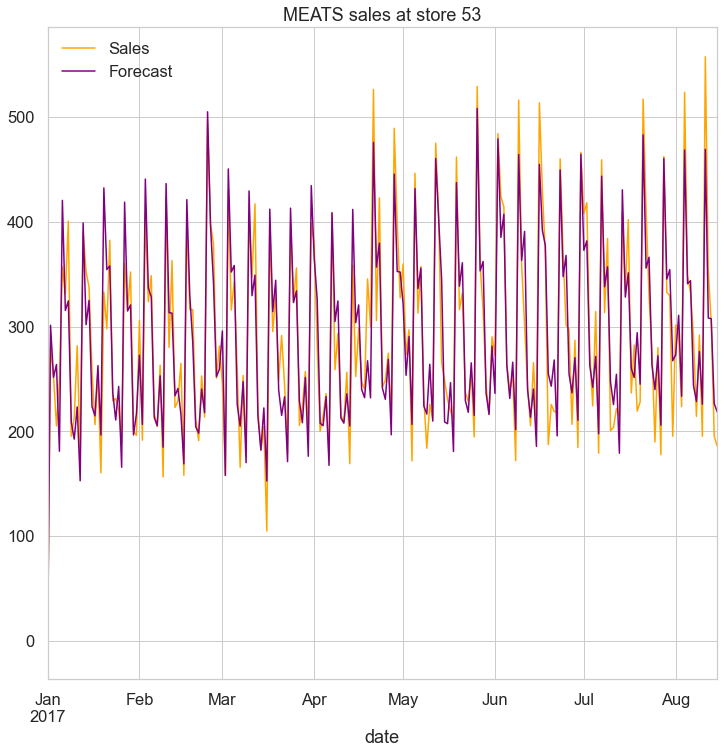

In [49]:
STORE_NBR = '53'
FAMILY = 'MEATS'
ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(color='orange', label='Sales')
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, color='purple', label='Forecast')
ax.set_title(f'{FAMILY} sales at store {STORE_NBR}');
plt.legend(loc='upper left');

## 💾 **Saving**

#### Changing the format from MultiIndex Columns to just one index column

In [24]:
# Copying so I don't mess with the original
aux = y_pred.copy()

In [25]:
# Undoing the unstacking and reseting the index to date
aux = aux.stack(['store_nbr', 'family']) 
aux.reset_index(inplace=True)
aux = aux.set_index('date')
display(aux.head())
display(aux.shape)

,store_nbr,family,sales
date,,,
2017-01-01,1,AUTOMOTIVE,2.955812
2017-01-01,1,BABY CARE,0.000000
2017-01-01,1,BEAUTY,-0.514723
2017-01-01,1,BEVERAGES,299.210982
2017-01-01,1,BOOKS,0.292253


(29964, 3)

Saving...

In [26]:
#aux.to_csv('forecasting results/forecast_results.csv')

## 🔎 **Analyzing the model**

### **Features Importance**

Getting the coefficients from the model

In [27]:
importance = model.coef_[0]
importance # pesos de cada feature

array([ 8.35656689e-03, -2.76606149e+00, -1.03885055e+00, -2.94092433e-01,
        2.53208162e+00, -6.18152948e-01,  2.65921464e+00, -4.74138848e-01,
        6.10902986e-01,  5.43460152e-01, -8.94243920e-02,  7.47440572e-02,
       -1.89956702e-02,  3.08053854e-01, -1.31361750e-01,  1.23938464e-01,
        1.84931923e-01, -2.98191718e-01,  9.64964495e-02, -2.65223750e-01,
       -6.72426403e-01,  6.85767398e-03,  1.52900793e-01, -2.06711223e-01,
        7.25298434e-01,  1.06509409e-01,  1.00533637e-01,  5.24443352e-01,
        1.06059543e-01, -5.22006028e-02,  2.98889397e-01,  2.43853870e-01,
       -3.06802776e+00,  1.93102506e+00, -3.78826445e-04,  3.11267381e-05,
        8.36634429e-01,  4.60639305e-01])

Dictionary

In [28]:
feature_score = {}
for i,v in enumerate(importance):
	feature_score[i] = v # {number: weight}

DataFrame

In [29]:
df_features_importance = pd.DataFrame.from_dict(feature_score, orient='index', columns=['score_original'])
df_features_importance['feature_name'] = X.columns
df_features_importance['abs_score'] = abs(df_features_importance.score_original)
df_features_importance.head()

,score_original,feature_name,abs_score
0,0.008357,trend,0.008357
1,-2.766061,"s(1,7)",2.766061
2,-1.038851,"s(2,7)",1.038851
3,-0.294092,"s(3,7)",0.294092
4,2.532082,"s(4,7)",2.532082


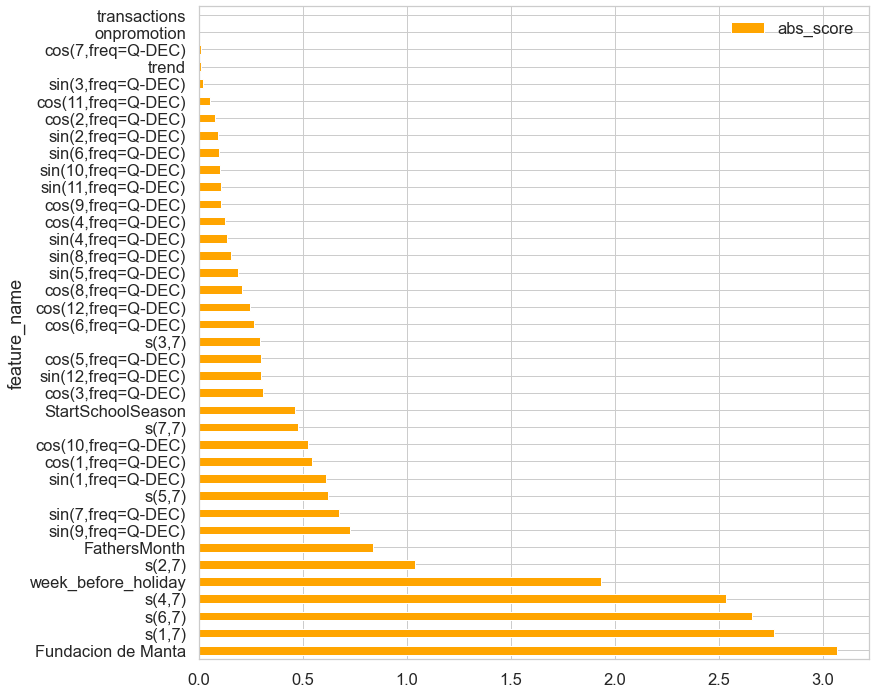

In [30]:
df_features_importance.sort_values(by='abs_score', ascending=False).plot(kind='barh', x='feature_name', y='abs_score', figsize=(12,12), color='orange');

Best 5 features

In [31]:
top_5_features = df_features_importance[['abs_score', 'feature_name']].sort_values(by='abs_score', ascending=False).head(5)
top_5_features

,abs_score,feature_name
32,3.068028,Fundacion de Manta
1,2.766061,"s(1,7)"
6,2.659215,"s(6,7)"
4,2.532082,"s(4,7)"
33,1.931025,week_before_holiday


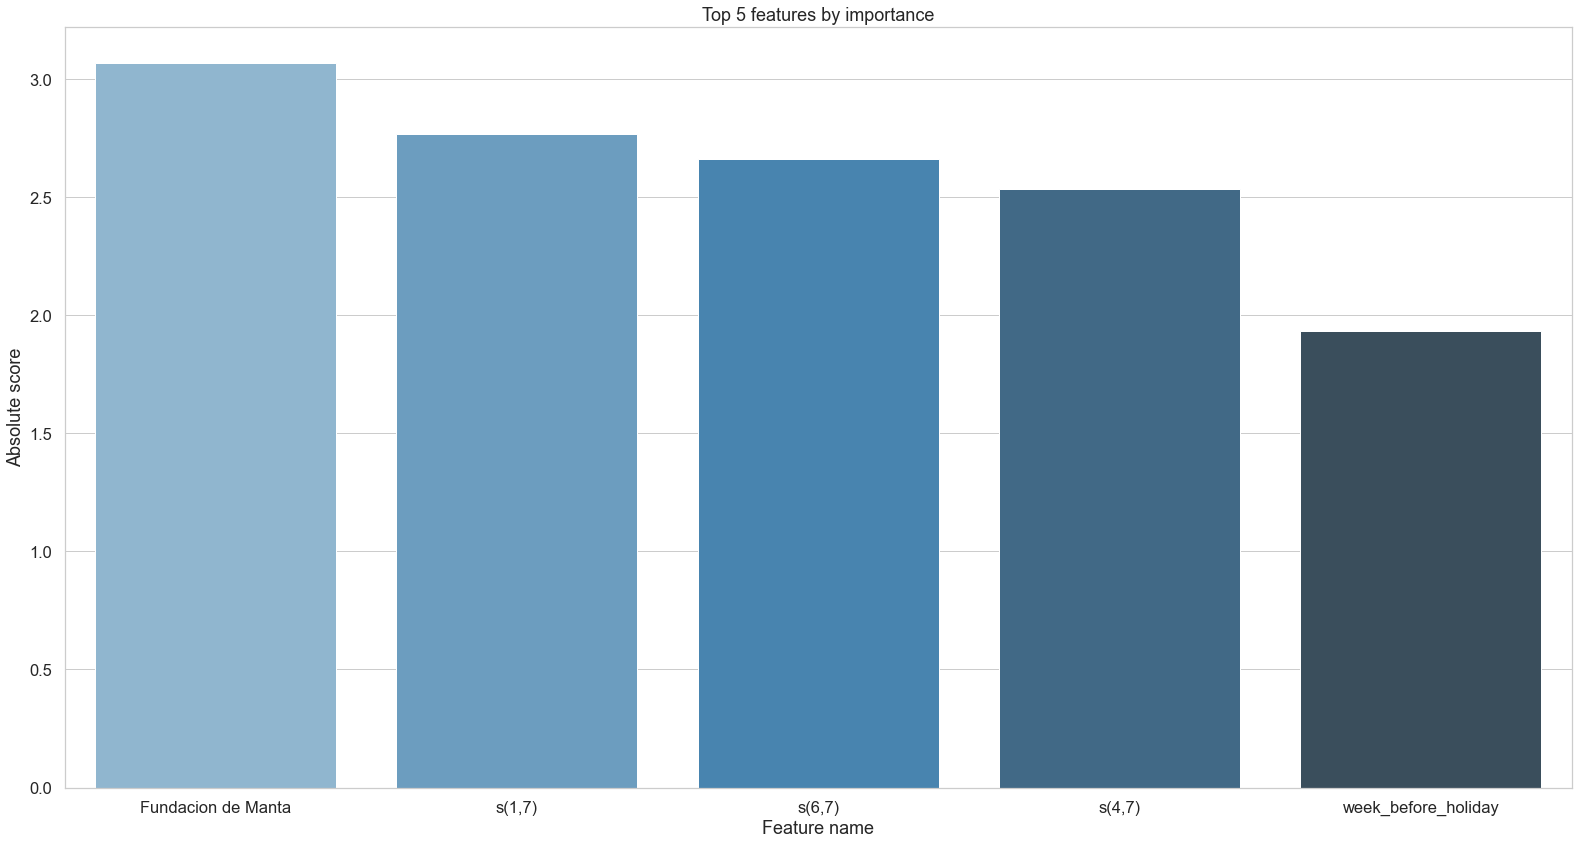

In [32]:
plt.figure(figsize=(27,14))
sns.barplot(x='feature_name', y='abs_score', data=top_5_features, palette='Blues_d').set_title('Top 5 features by importance')

plt.xlabel('Feature name')
plt.ylabel('Absolute score');

### **Metrics**

##### Changing the format from MultiIndex Columns to just one index column

###### Real y values

In [33]:
y_real = y.copy()
y_real = y_real.stack(['store_nbr', 'family']) 
y_real.reset_index(inplace=True)
y_real = y_real.set_index('date')

In [34]:
display(y_real.head())
display(y_real.shape)

,store_nbr,family,sales
date,,,
2017-01-01,1,AUTOMOTIVE,0.0
2017-01-01,1,BABY CARE,0.0
2017-01-01,1,BEAUTY,0.0
2017-01-01,1,BEVERAGES,0.0
2017-01-01,1,BOOKS,0.0


(29964, 3)

###### Predicted y values

In [35]:
y_previsto = aux.copy()
display(y_previsto.head())
display(y_previsto.shape)

,store_nbr,family,sales
date,,,
2017-01-01,1,AUTOMOTIVE,2.955812
2017-01-01,1,BABY CARE,0.000000
2017-01-01,1,BEAUTY,-0.514723
2017-01-01,1,BEVERAGES,299.210982
2017-01-01,1,BOOKS,0.292253


(29964, 3)

#### **Mean Absolute Error**

In [36]:
mean_absolute_error(y_real.sales, y_previsto.sales).round(2)

36.31

#### **Mean Squared Error**

In [37]:
mean_squared_error(y_real.sales, y_previsto.sales).round(2)

11742.11

#### **Root Mean Squared Error**

In [38]:
mean_squared_error(y_real.sales, y_previsto.sales, squared=False).round(2)

108.36

#### **Root Mean Squared Logarithmic Error (Kaggle evaluation)**

###### RMSLE metric only considers the relative error between and the Predicted and the actual value and the scale of the error is not significant. On the other hand, RMSE value Increases in magnitude if the scale of error increases.

###### $$ Y = 10000 $$


###### $$ X = 9000 $$

###### Calculated RMSLE: 0.1053

###### Calculated RMSE : 1000

In [39]:
#mean_squared_log_error(y_real.sales, y_previsto.sales)

```python
ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
```

##### **Using absolute values**

In [40]:
y_real_sales = y_real.sales.values
y_prev_sales = abs(y_previsto.sales.values)

In [41]:
mean_squared_log_error(y_real_sales, y_prev_sales)

0.16103985389544986

In [42]:
math.sqrt(mean_squared_log_error(y_real_sales, y_prev_sales))

0.4012977122978025

### **Scatters**

In [43]:
y_real_sales = y_real_sales.astype(float).round(2)
y_prev_sales = y_prev_sales.round(2)
residuals = y_real_sales - y_prev_sales

In [44]:
real_x_predicted = pd.DataFrame({'y_real': y_real_sales, 'y_prev': y_prev_sales, 'residual':residuals}, index=aux.index)
real_x_predicted['y_real'] = real_x_predicted.y_real
real_x_predicted.tail()

,y_real,y_prev,residual
date,,,
2017-08-15,434.57,419.64,14.93
2017-08-15,102.34,64.26,38.08
2017-08-15,2073.64,1961.48,112.16
2017-08-15,0.00,0.03,-0.03
2017-08-15,47.58,26.11,21.47


#### Real X Predicted

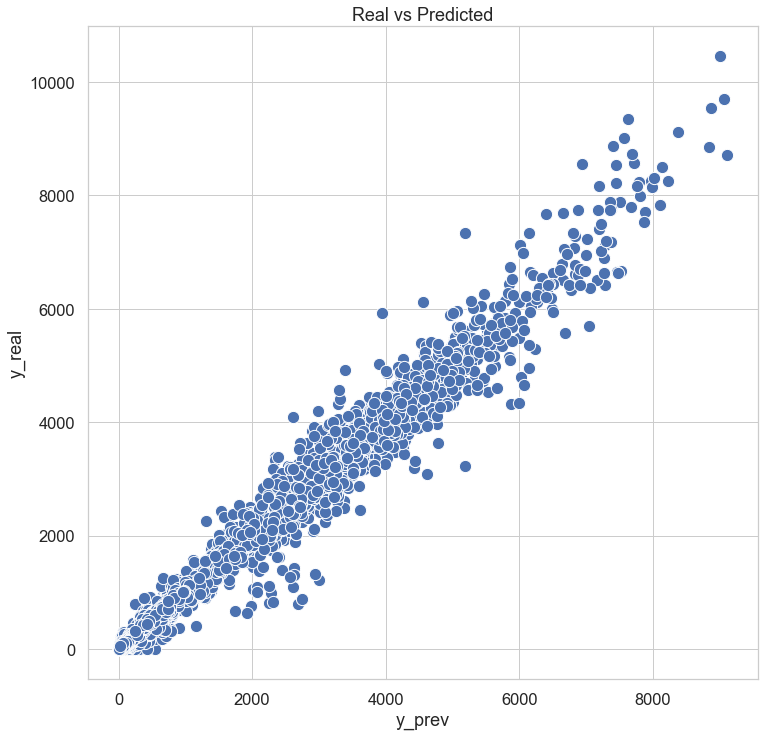

In [45]:
sns.scatterplot(
    x='y_prev', 
    y='y_real', 
    data=real_x_predicted, 
    palette='Blues_d', s=150
    ).set_title('Real vs Predicted');

#### Residuals

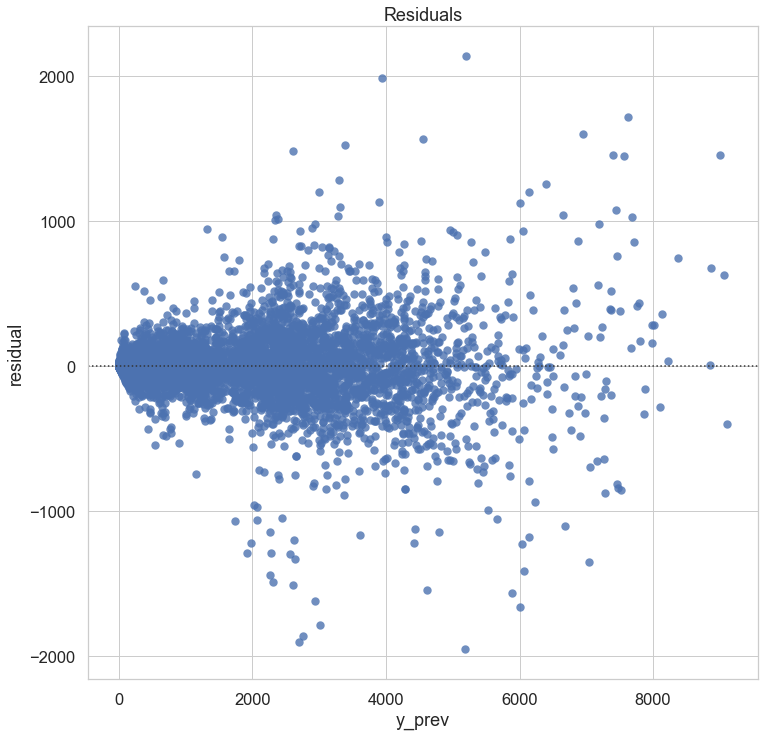

In [46]:
sns.residplot(
    x=real_x_predicted.y_prev, 
    y=real_x_predicted.residual, 
    data=real_x_predicted, 
    scatter_kws={'s':70},
    ).set_title('Residuals');